## Fig 4A: Mutant screen confidence interval plots
<p> The following code will generate plots of the mean difference confidence intervals for tax-4/N2, osm-9/N2 and tax-4:osm-9 double/N2. These plots represent the mean difference in response compared to the mean of the null response to DMSO:DMSO and DMSO:H2O</p>

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import pandas as pd
import numpy as np

#### Reading in and cleaning up the datasets
<p> When we are generating this plot we want to order the mutant data according to the N2 response. This helps us to visualize the change in response, if any.</p>

In [37]:
#Generating a function that subsets the data for a single 'control' condition
def subset_ref_comp(df, ref, strain):
    dat = df.loc[(df['control'] == ref) & (df['Strain'] == strain)]
    dat =dat.sort_values('difference')
    #Two compounds accidently made it into the mutant screen that should have been excluded due to a sorting error
    dat = dat.loc[(dat['test'] != '2-Nonylquinolin-4(1H)-one') & (dat['test'] != 'Rosmarinic acid')]
    dat = dat.reset_index(drop=True)
    return dat


In [38]:
#Reading all relevant datasets

N2dat = pd.read_csv('C:/Users/Emily/Documents/S1/inner3.csv', index_col=0)
N2dat['Strain'] = 'N2'
all_strains = pd.read_csv('C:/Users/Emily/Documents/S1f2/all_strains_nullrefs_mdiff.csv', index_col=0)

In [39]:
all_strains.head()

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,Strain
0,DMSO,(-)-Huperzine A,851,675,mean difference,False,2.506552,95,1.196282,3.777346,...,12345,0.0002,5000,1.410690e-04,-3.816288,1.548620e-04,-3.792664,3.505100e-04,256649.0,PR678
1,DMSO,1-octanol,851,668,mean difference,False,-3.953032,95,-5.293354,-2.707069,...,12345,0.0000,5000,1.940000e-09,6.040730,2.570000e-09,5.992922,4.770000e-09,333919.0,PR678
2,DMSO,"2,3-Dihydrobenzofuran",851,670,mean difference,False,6.791056,95,5.381876,8.232949,...,12345,0.0000,5000,1.420000e-19,-9.193824,2.960000e-20,-9.352530,5.060000e-19,209306.0,PR678
3,DMSO,"2,5-Dihydroxybenzoic acid",851,998,mean difference,False,1.256955,95,0.014839,2.370033,...,12345,0.0378,5000,3.894494e-02,-2.066285,3.872075e-02,-2.068619,7.237558e-02,404089.0,PR678
4,DMSO,2-Methyl-1-butanol,851,640,mean difference,False,1.722631,95,0.324622,3.058874,...,12345,0.0140,5000,1.332786e-02,-2.478130,1.303927e-02,-2.485684,2.376176e-02,253714.0,PR678


In [40]:
#Generating a function that subsets the data for a single 'control' condition. When the confidence intervals are generated
#the control condition is omitted from the 'test' column and thus needs to be placed back into the df so it's not missing
#in the plot

def data_to_plot(strain, ref, df):
    data = subset_ref_comp(df, ref, strain)

    data = data.loc[data['control']== ref]
    data = data.sort_values('difference')
    data = data.reset_index(drop=True)

    if ref == 'DMSO':
        not_missing = 'H2O'
        missing_index = data.index[data['test'] == not_missing].values[0]
    else:
        not_missing = 'DMSO'
        missing_index = (data.index[data['test'] == not_missing].values[0])+1
  
    
    line = pd.DataFrame({"control": ref , "test": ref, 'test_N':"NaN", 
                         "difference":"NaN", "bca_low":"NaN", "bca_high":"NaN"}, index=[missing_index])
    all_data = pd.concat([data.iloc[:missing_index], line, data.iloc[missing_index:]]).reset_index(drop=True)
    return all_data


#### We are using the sorted N2 mean differences (calculated for the 95% confidence intervals) for all testing conditions relative to DMSO. This list will be passed to the function call below.

In [41]:
N2DMSO = data_to_plot('N2', 'DMSO', N2dat)
comp_ord= N2DMSO['test']

#### Generating vertical line plots to visualize the difference in response between N2 and mutant strains for both DMSO and water conditions

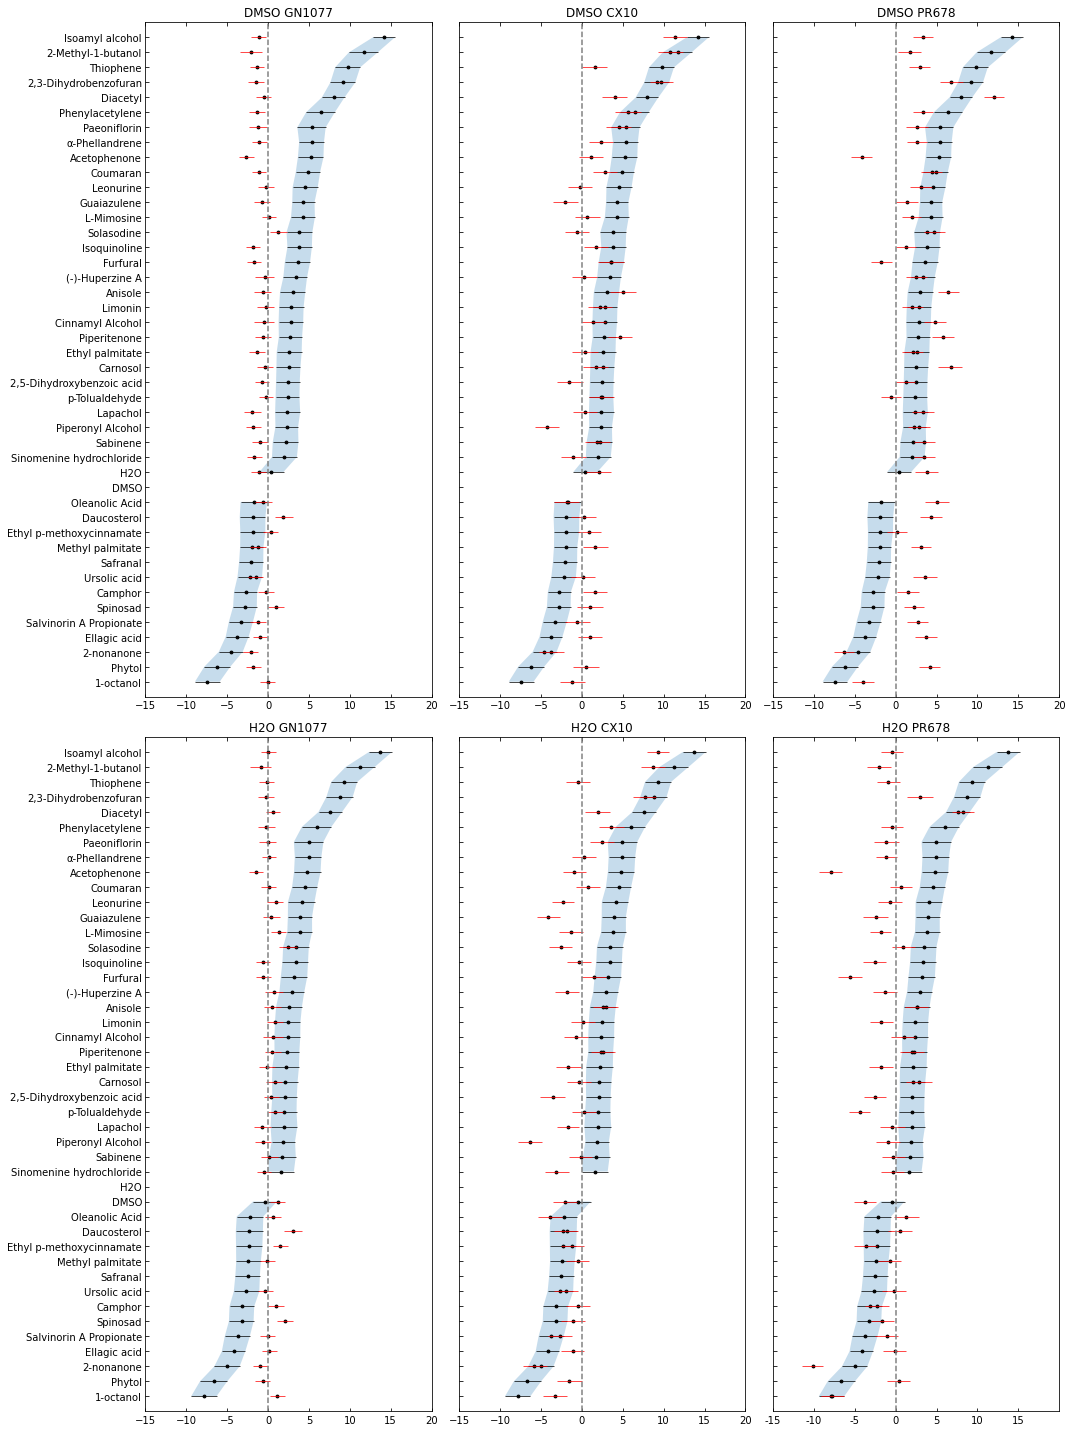

In [44]:
strains = ['GN1077', 'CX10', 'PR678']
comps = ['DMSO', 'H2O']

fig, ax = plt.subplots(figsize=(15,20), nrows=len(comps), ncols=(len(strains)), sharey=True) 

for i in strains:
        
    for j in comps:
        mutant_dat = data_to_plot(i, j, all_strains)
        
        c = strains.index(i)
        r = comps.index(j)
        
        if j == 'DMSO':
            N2_dat = data_to_plot('N2', j , N2dat)
        elif j == 'H2O':
            N2_dat = data_to_plot('N2', j , N2dat)
   
        positions = list(range(0, len(comp_ord)))
        ref_dat1 = N2_dat.loc[N2_dat['control']==j]
        ref_dat1 = ref_dat1.set_index('test')

        reordered1 = ref_dat1.reindex(comp_ord)
        reordered1 = reordered1.reset_index()
        reordered1['bca_low'] = reordered1['bca_low'].astype(np.float64)
        reordered1['bca_high'] = reordered1['bca_high'].astype(np.float64)

        
        lines1 = []
        for index, row in reordered1.iterrows():
            line = ((row['bca_low'], index), (row['bca_high'], index))
            lines1.append(line)

        ref_dat2 = mutant_dat.loc[mutant_dat['control']==j]
        ref_dat2 = ref_dat2.set_index('test')

        reordered2 = ref_dat2.reindex(comp_ord)
        reordered2 = reordered2.reset_index()

        lines2 = []
        for index, row in reordered2.iterrows():
            line = ((row['bca_low'], index), (row['bca_high'], index))
            lines2.append(line)
        
        ax[r,c].fill_betweenx(positions, reordered1['bca_low'], reordered1['bca_high'], alpha=.25)
        ytick_labels = list(reordered1['test'])

        mdiffs1 = list(reordered1['difference'])
        mdiffs2 = list(reordered2['difference'])

        #fig, ax = plt.subplots(figsize=(5,10)) 

        hln_coll1 = mpl.collections.LineCollection(lines1, colors='black', linewidths = .7)
        hln_coll2 = mpl.collections.LineCollection(lines2, colors='red', linewidths = .7)
        #ax[r,c] = plt.gca()


        x_positions = list(np.arange(-15, 20, 5))

        plt.yticks(positions, ytick_labels )
        plt.xticks(x_positions, x_positions)
        
        
        ax[r,c].xaxis.set_ticks_position('both')
        ax[r,c].add_collection(hln_coll1)
        ax[r,c].add_collection(hln_coll2)
        ax[r,c].scatter(mdiffs1, positions, s=8, c='black')
        ax[r,c].scatter(mdiffs2, positions, s=8, c='black')
        ax[r,c].tick_params(axis='both', tickdir='in')
        
        ax[r,c].set_xlim(-15, (20))    
        ax[r,c].set_ylim(-1, len(comp_ord))
        ax[r,c].set_title(j + ' ' + i)
        ax[r,c].axvline(0, ls='--', c='gray')
        plt.tight_layout()
        plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('C:/Users/Emily/Desktop/NPScreen_figs/Images/Fig4/allmuts_mdiffPlot.svg')
